In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import gzip
import pandas as pd
import numpy as np
from datetime import timezone
import datetime
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, ks_2samp
from statsmodels.tsa.stattools import acf
cme_format = '%Y%m%d%H%M%S%f'
dt = datetime.timedelta(hours=4)

In [3]:
ticker = "ESM0"
datestr = "20100506"
directory = 'D:/projects/data/XCME/2010/{0}/{1}/MD/XCME/'.format(datestr[-4:-2], datestr[-2:])
start = pd.to_datetime(datestr+'080000', format=cme_format)
end = pd.to_datetime(datestr+'170000', format=cme_format)
scale = 100
tick_size = 0.25

In [4]:
lob = pd.read_csv(directory+ticker+'.csv', header=0)
lob['time'] = pd.to_datetime(lob['time'], format=cme_format) - dt
lob.set_index('time', inplace=True)
lob = lob.loc[start:end]
new_lob = lob[~lob.index.duplicated(keep="first")]
h_spread = (new_lob['AskPrc_1'] - new_lob['BidPrc_1']) / scale / tick_size
raw_mid = (new_lob['AskPrc_1'] + new_lob['BidPrc_1']) * 0.5 / scale
mid = raw_mid.resample('1S').apply(lambda i: i[-1] if len(i) > 0 else np.nan).fillna(method='ffill').dropna()
lob.shape
del lob

<AxesSubplot:xlabel='time'>

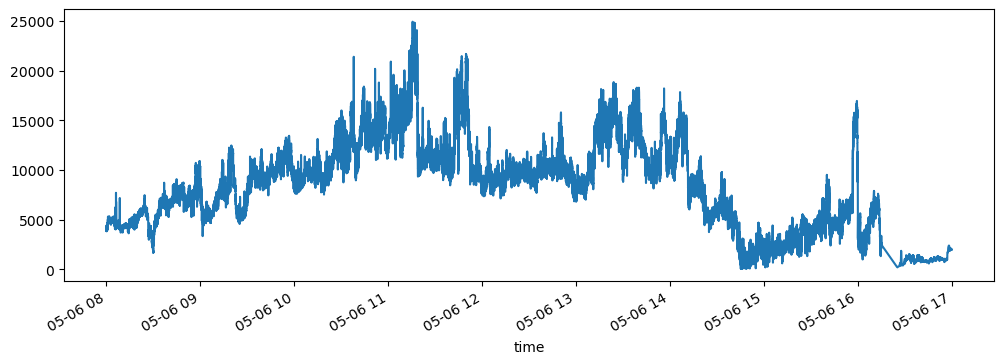

In [5]:
new_lob.filter(like='BidQty_').sum(axis=1)[::20].plot(figsize=(12, 4))

In [6]:
tmp = raw_mid.resample('1S').last().fillna(method='ffill').dropna()
close = tmp.bfill().values
h_ret = close[1:] / close[:-1] - 1

In [7]:
# Order frequency
# No. of seconds:
num_secs = 9 * 3600
num_events = len(new_lob)
avg_events = num_events / num_secs
avg_events

101.9429012345679

In [8]:
trades = pd.read_csv(directory+ticker+'_trades.csv', header=0)
trades['time'] = pd.to_datetime(trades['time'], format=cme_format) - dt
trades.set_index('time', inplace=True)
trades['Prc'] = trades['Prc'] / scale
trades = trades.loc[start:end]
print(trades.shape)
# Trades frequency
trades_freq = len(trades) / num_secs
print(trades_freq)
h_trades = trades.copy()
h_volume = h_trades['Qty'].resample('1min').sum().fillna(0)

(1093218, 5)
33.7412962962963


In [9]:
# Hill estimator
from CMECalibration.distance_calc import hill_estimator
hill_estimator(h_ret, tail=0.01)

0.4276957027189458

In [22]:
datestr = "20100503"
directory = 'D:/projects/data/XCME/2010/{0}/{1}/MD/XCME/'.format(datestr[-4:-2], datestr[-2:])
start = pd.to_datetime(datestr+'080000', format=cme_format)
end = pd.to_datetime(datestr+'170000', format=cme_format)
trades = pd.read_csv(directory+ticker+'_trades.csv', header=0)
trades['time'] = pd.to_datetime(trades['time'], format=cme_format) - dt
trades.set_index('time', inplace=True)
trades['Prc'] = trades['Prc'] / scale
trades = trades.loc[start:end]
print(trades.shape)
# Trades frequency
trades_freq = len(trades) / num_secs
print(trades_freq)
print(9*3600*1000/len(trades.index.unique()))

(294578, 5)
9.091913580246914
300.63188368144154


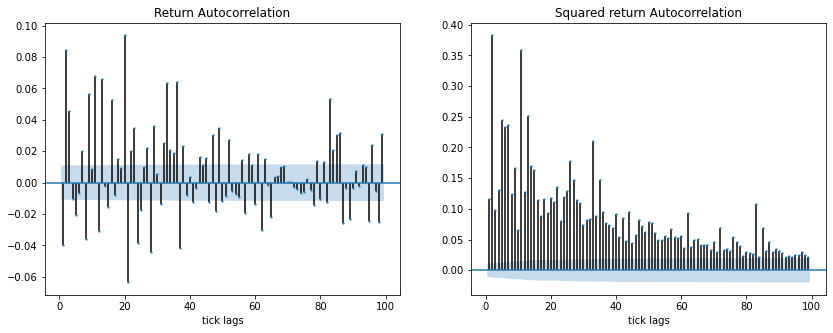

excess kurtosis of historical return: 240.86749739306106
skewness of historical return: -3.9822921218415415


In [9]:
from statsmodels.graphics.tsaplots import plot_acf
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(h_ret, ax=axs[0], lags=range(1,100), markersize=1.2, fft=True)
axs[0].set_title('Return Autocorrelation')
plot_acf(h_ret**2, ax=axs[1], lags=range(1,100), markersize=1.2, fft=True)
axs[1].set_title('Squared return Autocorrelation')
axs[0].set_xlabel('tick lags')
axs[1].set_xlabel('tick lags')
plt.show()
# Heavy tail analysis
print('excess kurtosis of historical return: {}'.format(kurtosis(h_ret)))
print('skewness of historical return: {}'.format(skew(h_ret)))

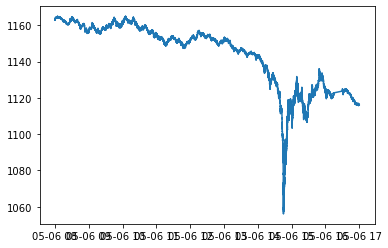

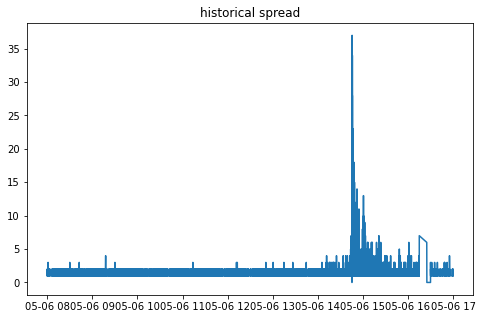

In [10]:
plt.plot(h_trades['Prc'])
plt.show()
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(h_spread)
ax.set_title('historical spread')
plt.show()

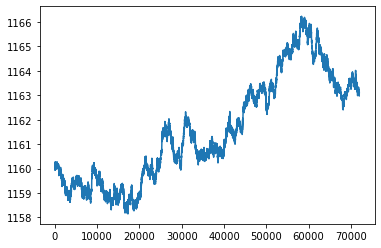

In [36]:
# GBM
mu = 1e-13
sigma = 5e-8
step = 100000
v = 1160
vs = [v]
for i in range(72000):
    v = v * np.exp((mu - 0.5*sigma**2)*step + np.random.normal(0, sigma*np.sqrt(step)))
    vs.append(v)
price = np.array(vs)
ret = price[1:] / price[:-1] - 1
plt.plot(price)

In [11]:
# For plotting the stylised facts
h_ret_dict = {}
for datestr in ['20100503', '20100504', '20100505', '20100506']:
    ticker = "ESM0"
    directory = 'D:/projects/data/XCME/2010/{0}/{1}/MD/XCME/'.format(datestr[-4:-2], datestr[-2:])
    start = pd.to_datetime(datestr+'080000', format=cme_format)
    end = pd.to_datetime(datestr+'170000', format=cme_format)
    scale = 100
    tick_size = 0.25
    lob = pd.read_csv(directory+ticker+'.csv', header=0)
    lob['time'] = pd.to_datetime(lob['time'], format=cme_format) - dt
    lob.set_index('time', inplace=True)
    lob = lob.loc[start:end]
    new_lob = lob[~lob.index.duplicated(keep="first")]
    h_spread = (new_lob['AskPrc_1'] - new_lob['BidPrc_1']) / scale / tick_size
    raw_mid = (new_lob['AskPrc_1'] + new_lob['BidPrc_1']) * 0.5 / scale
    mid = raw_mid.resample('1S').apply(lambda i: i[-1] if len(i) > 0 else np.nan).fillna(method='ffill').dropna()
    lob.shape
    del lob
    tmp = raw_mid.resample('1S').last().fillna(method='ffill').dropna()
    close = tmp.bfill().values
    h_ret = close[1:] / close[:-1] - 1
    h_ret_dict[datestr] = h_ret

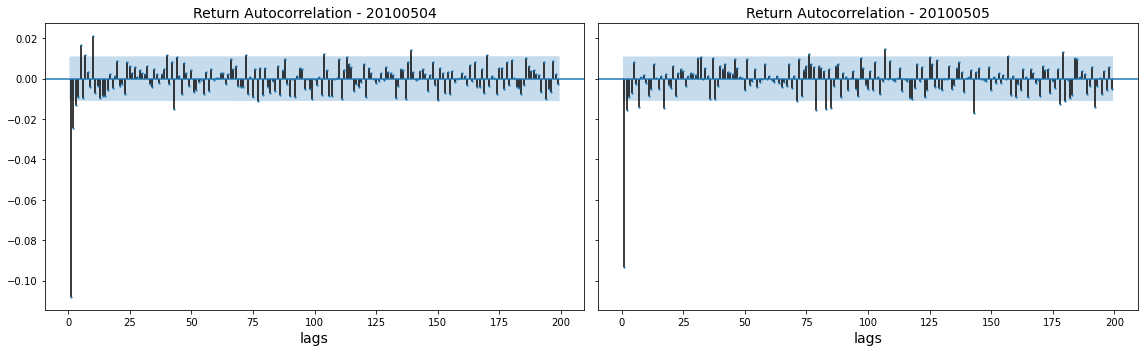

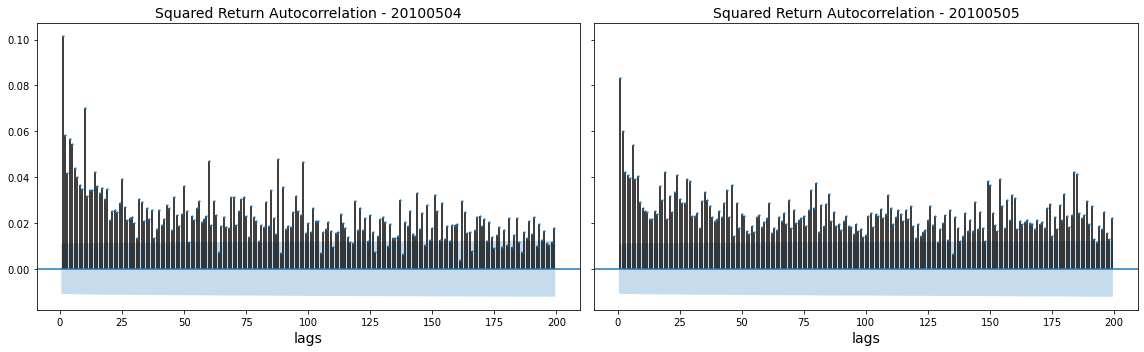

In [12]:
# For plotting the stylised facts
datestr_list = ['20100504', '20100505']
from statsmodels.graphics.tsaplots import plot_acf
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for i, datestr in enumerate(datestr_list):
    plot_acf(h_ret_dict[datestr], ax=axs[i], lags=range(1,200), markersize=1.2, fft=True)
    axs[i].set_title('Return Autocorrelation - %s'%datestr, size=14)
    # plot_acf(h_ret_dict[datestr]**2, ax=axs[i], lags=range(1,200), markersize=1.2, fft=True)
    # axs[i].set_title('Squared Return Autocorrelation - %s'%datestr)
    axs[i].set_xlabel('lags', size=14)
fig.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for i, datestr in enumerate(datestr_list):
    plot_acf(h_ret_dict[datestr]**2, ax=axs[i], lags=range(1,200), markersize=1.2, fft=True)
    axs[i].set_title('Squared Return Autocorrelation - %s'%datestr, size=14)
    axs[i].set_xlabel('lags', size=14)
fig.tight_layout()
plt.show()

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
def visualize_lob(start, end, data, middle=None):
    # Prepare level 2 order data
    lob = data.loc[start:end]
    # Prepare mid price data
    b0 = lob['BidPrc_1']
    a0 = lob['AskPrc_1']
    raw_mid = (a0 + b0) / 2.
    # Prepare trades data
    # trades = md['trades']
    # tmp_trades = trades.loc[start:end]
    # tmp_trades = tmp_trades[tmp_trades.SIDE=='Buy']
    # low = tmp.min() // tick_size * tick_size - 20 * tick_size
    # high = tmp.max() // tick_size * tick_size + 20 * tick_size
    # low = 127.2
    # high = 128.50
    # print('trades number: %d' % len(tmp_trades))
    # Re-scale the trades executed size
    # display_max = 250
    # display_min = 30
    # trades_vol = tmp_trades.EXECUTEDSIZE
    # if len(tmp_trades) > 1 and trades_vol.max() > trades_vol.min():
    #     trades_display_size = list((trades_vol - trades_vol.min()) / (trades_vol.max() - trades_vol.min()) * \
    #                                (display_max - display_min) + display_min)
    # else:
    #     trades_display_size = (display_max + display_min) / 2
    # min_vol = lob.vol.min()
    # max_vol = lob.vol.max()
    max_vol = 2000
    min_vol = 100
    cNorm = colors.Normalize(vmin=min_vol, vmax=max_vol)
    cm = plt.get_cmap('Greens')
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    unique_ts = sorted(lob.index.unique())
    fig, ax = plt.subplots(figsize=(24, 8))
    ax.grid(False)
    ax.set_facecolor('#fccdca')
    spread_label = 'spread'
    for ts in range(len(unique_ts)-1):
        left = unique_ts[ts]
        right = unique_ts[ts+1]
        tmp_lob = lob.loc[left]
        best_bid = tmp_lob['BidPrc_1']
        best_ask = tmp_lob['AskPrc_1']
        for i in range(1, 11, 1):
            ax.hlines(y=tmp_lob['BidPrc_'+str(i)], xmin=left, xmax=right, linewidth=5, color=scalarMap.to_rgba(tmp_lob['BidQty_'+str(i)]))
            ax.hlines(y=tmp_lob['AskPrc_'+str(i)], xmin=left, xmax=right, linewidth=5, color=scalarMap.to_rgba(tmp_lob['AskQty_'+str(i)]))
        ax.fill_between([left,right], y1=best_ask, y2=best_bid, label=spread_label, facecolor='0.5', alpha=0.4)
        spread_label = None

    ax.plot(raw_mid.index, raw_mid, 'o-', label="mid price", drawstyle='steps-post')
    # if len(tmp_trades) > 0:
    #     ax.scatter(tmp_trades.index, tmp_trades['EXECUTEDPRICE'], s=trades_display_size, color='red', label="trades(total:%d)"%trades_vol.sum(), zorder=3)
    # ax.plot(tmp_trades.index, tmp_trades['EXECUTEDPRICE'], marker='o', markersize=8, color='red', label="trades", ls='')
    if middle is not None:
        ax.axvline(middle, color='red', alpha=0.3)
    ax.set_title("level 2 LOB, %s - %s"%(start.strftime('%Y-%m-%d %H:%M:%S.%f'), end.strftime('%H:%M:%S.%f')), size='xx-large')
    ax.legend(loc='best', fontsize='x-large')
    ax.tick_params(axis='both', which='both', labelsize=15)
    # ax.set_ylim((low, high))
    cbar = plt.colorbar(scalarMap, orientation='vertical')
    cbar.ax.tick_params(labelsize=10) 
    cbar.set_label(label='order size', weight='bold', size=20)
    plt.show()

In [ ]:
start = pd.to_datetime('20100504154205700', format=cme_format)
end =   pd.to_datetime('20100504154206000', format=cme_format)
print(start, end)
visualize_lob(start, end, new_lob)

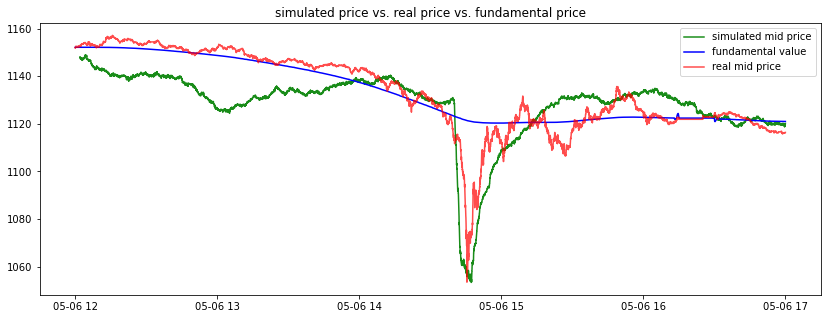

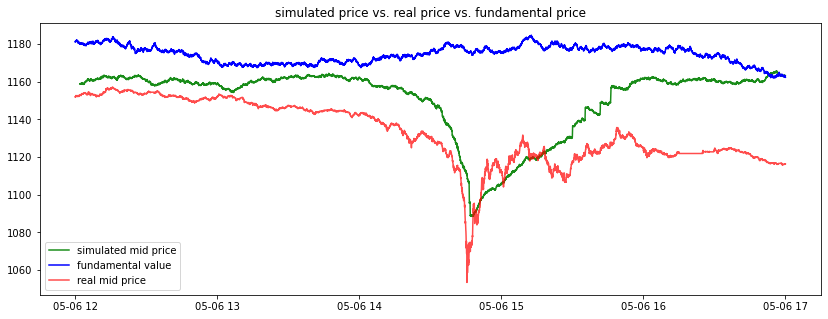

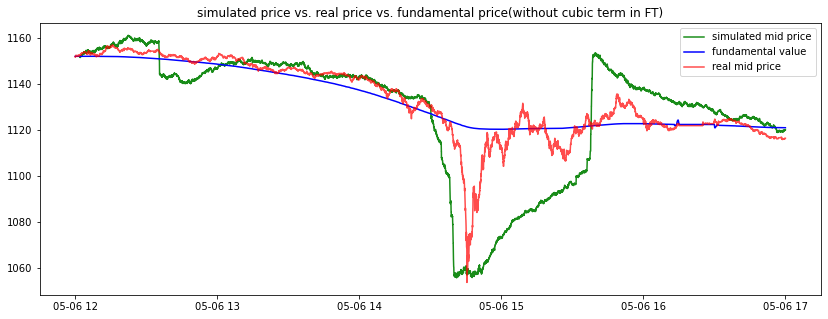

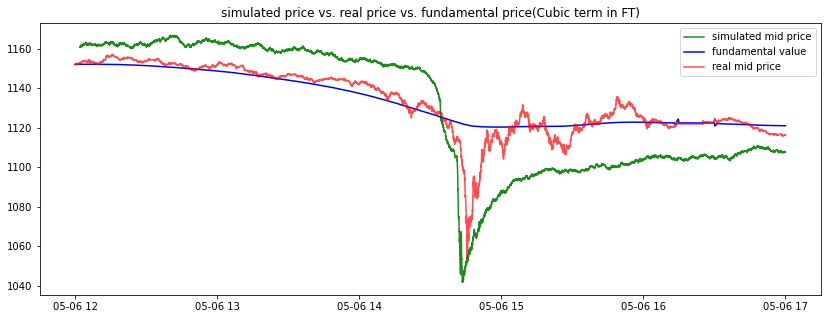

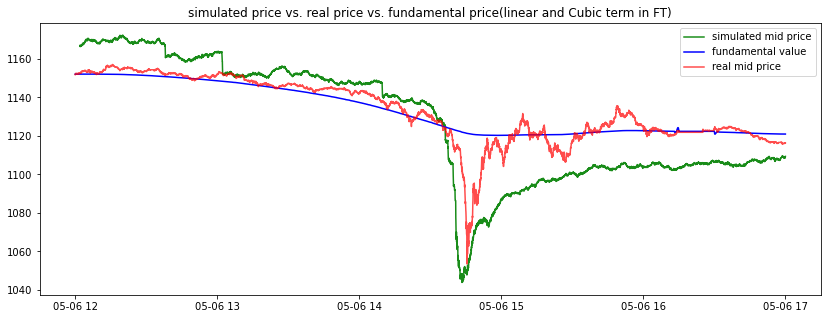

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from matplotlib import cm
import json
from scipy.stats import kurtosis, skew, ks_2samp
from statsmodels.tsa.stattools import acf
turquoise_datetime_format = "%d-%b-%Y %H:%M:%S.%f"

In [33]:

tick_size = 0.25
datestr = '20100506'
start = pd.to_datetime(datestr + ' 08:00:00')
end = pd.to_datetime(datestr + ' 17:00:00')

In [34]:
def get_synthetic_market_data(data_path, tick_size=.02):
    df_lob_l1 = pd.read_csv('{0}/lob_l1.csv'.format(data_path)).set_index('time')
    df_lob_l1.index = pd.to_datetime(df_lob_l1.index, format=turquoise_datetime_format)

    l1B = df_lob_l1[df_lob_l1['side']  == 'B']
    l1S = df_lob_l1[df_lob_l1['side']  == 'S']
    
    mp = .5 * l1B['prc'] + .5 * l1S['prc']
    spread = l1S['prc'] - l1B['prc']
    spread = np.round(spread.fillna(method='ffill').fillna(method='bfill') / tick_size).dropna().astype(int)
    
    orders = pd.read_csv('{0}/orders.csv'.format(data_path)).set_index('time')
    orders.index = pd.to_datetime(orders.index, format=turquoise_datetime_format)
    
    b0 = l1B['prc'].shift(1)
    a0 = l1S['prc'].shift(1)
    depth_b = np.round((b0.reindex(orders.index) - orders['prc']) / tick_size)
    depth_a = np.round((orders['prc'] - a0.reindex(orders.index)) / tick_size)

    orders.loc[:,'depth'] = ((orders['side'] == 'B') * depth_b + (orders['side'] == 'S') * depth_a).values
    
    market_orders = orders[orders['OrdType'] == 'M'].copy()
    
    trades = pd.read_csv('{0}/trades.csv'.format(data_path)).set_index('time')
    trades.index = pd.to_datetime(trades.index, format=turquoise_datetime_format)
    
    pos = pd.read_csv('{0}/agentPosition.csv'.format(data_path)).set_index('time')
    pos.index = pd.to_datetime(pos.index, format=turquoise_datetime_format)
    
    md = {'l1B': l1B, 'l1S': l1S, 'mp': mp, 'spread': spread, 'orders': orders, 'trades': trades, 'a0': a0, 'b0': b0, 'market_orders': market_orders, 'lob_l1': df_lob_l1, 'pos': pos}
    return md

def get_fv_mv_value(data_path):
    fv = pd.read_csv('{0}/fundamental_value.csv'.format(data_path)).set_index('timestamp')
    fv.index = pd.to_datetime(fv.index, format=turquoise_datetime_format).floor('S')
    mv = pd.read_csv('{0}/momentum_value.csv'.format(data_path)).set_index('timestamp')
    mv.index = pd.to_datetime(mv.index, format=turquoise_datetime_format).floor('S')
    return fv.squeeze(), mv.squeeze()

In [35]:
data_path = 'CME/Results/run_00000'
# data_path = '../../MultipleRun/Results/run_00000'
md = get_synthetic_market_data(data_path, tick_size=tick_size)
l1B, l1S, raw_mp, spread, orders, trades, market_orders, lob_l1, pos = md['l1B'], md['l1S'], md['mp'], md['spread'], md['orders'], md['trades'], md['market_orders'], md['lob_l1'], md['pos']
raw_mp = raw_mp.dropna().loc[start:end]
fv, mv = get_fv_mv_value(data_path)
min_mp = raw_mp.resample('1min').last().fillna(method='ffill').dropna()
mp = raw_mp.resample('1S').last().fillna(method='ffill').dropna()
# ret_s = (mp.values[1:] / mp.values[:-1] - 1) * 10000
# raw_ret_s = (raw_mp.values[1:] / raw_mp.values[:-1] - 1) * 10000
distortion = mp - fv
L_num = (orders['OrdType'] == 'L').sum()
# trades['ret'] = trades['prc'].shift(-1) / trades['prc']-1
# s_ret = trades['ret'].dropna().values
buy_l1 = lob_l1[lob_l1['side'] == 'B'].copy()
sell_l1 = lob_l1[lob_l1['side'] == 'S'].copy()

tmp = raw_mp.resample('1S').last().fillna(method='ffill').dropna()
close = tmp.bfill().values
s_ret = close[1:] / close[:-1] - 1

In [36]:
# Price drop percentage
left = pd.to_datetime(datestr + ' 14:40:50')
right = pd.to_datetime(datestr + ' 14:42:20')
l_p = tmp.loc[left]
r_p = tmp.loc[right]
# r_p = tmp.min()
print(l_p, r_p)
print((l_p - r_p) / l_p)

1102.75 1056.875
0.04160054409430968


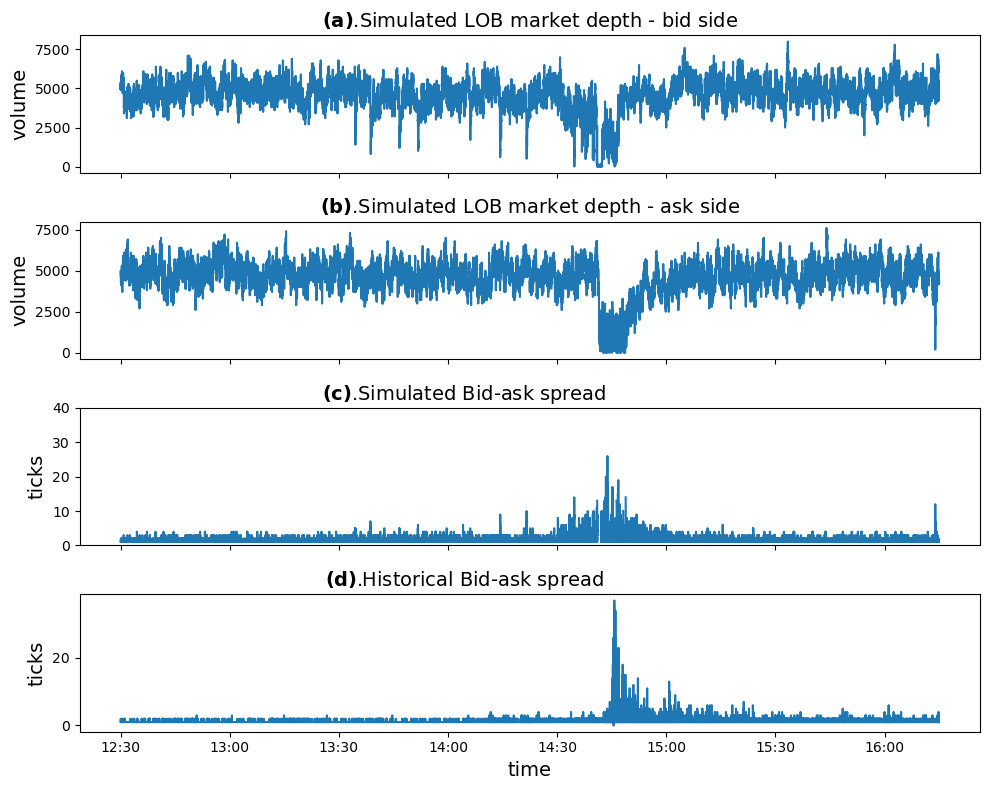

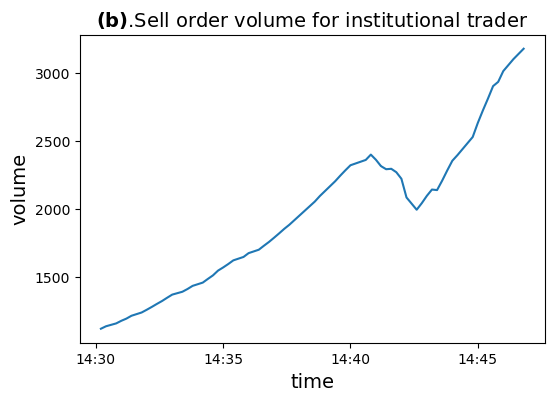

In [37]:
left = pd.to_datetime(datestr + ' 12:30:00')
right = pd.to_datetime(datestr + ' 16:15:00')
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
axs[0].plot(buy_l1['total_vol'].loc[left:right][::5])
axs[0].set_title(r'$\bf{(a)}$.Simulated LOB market depth - bid side', size=14)
axs[0].set_ylabel('volume', size=14)
axs[1].plot(sell_l1['total_vol'].loc[left:right][::5])
axs[1].set_title(r'$\bf{(b)}$.Simulated LOB market depth - ask side', size=14)
axs[1].set_ylabel('volume', size=14)
spread = (l1S['prc'] - l1B['prc']).loc[left:right] / tick_size
axs[2].plot(spread)
axs[2].set_title(r'$\bf{(c)}$.Simulated Bid-ask spread                      ', size=14)
axs[2].set_ylabel('ticks', size=14)
axs[2].set_ylim((0, 40)) ### temporary
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
tmp_h_spread = h_spread.loc[left:right]
axs[3].plot(tmp_h_spread)
axs[3].set_title(r'$\bf{(d)}$.Historical Bid-ask spread                      ', size=14)
axs[3].set_xlabel('time', size=14)
axs[3].set_ylabel('ticks', size=14)
axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(orders[orders['TraderType'] == 'INS']['vol'])
ax.set_title(r'$\bf{(b)}$.Sell order volume for institutional trader', size=14)
ax.set_xlabel('time', size=14)
ax.set_ylabel('volume', size=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

## LOB Analysis

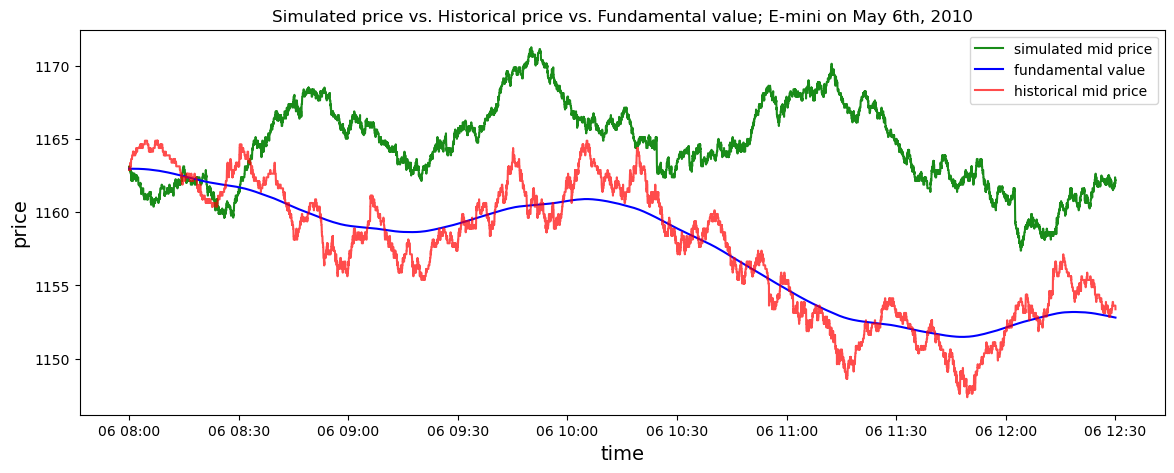

In [38]:
# When alpha changes
# figs, axes = plt.subplots(1,3, figsize=(21, 4))
# axes[0].plot(mv.values, distortion.values)
# axes[0].set_xlabel("Momentum")
# axes[0].set_ylabel("Price distortion")
# # ax.set_xlim((-1,1))

# axes[1].plot(distortion)
# axes[1].set_xlabel("Time")
# axes[1].set_ylabel("Price distortion")

# axes[2].plot(mp, label='mid price')
# axes[2].plot(fv, label='fundamental value')
# axes[2].set_title('mid price vs. fundamental price')
# axes[2].legend(loc='best')
# plt.show()

# left, right = 0, 44700
left = pd.to_datetime(datestr + ' 08:00:00')
right = pd.to_datetime(datestr + ' 12:30:00')
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(mp.loc[left:right], 'g', alpha=0.9, label='simulated mid price')
ax.plot(fv.loc[left:right], 'b', label='fundamental value')
ax.plot(mid.loc[left:right], 'r', alpha=0.7, label='historical mid price')
ax.set_title('Simulated price vs. Historical price vs. Fundamental value; E-mini on May 6th, 2010')
ax.legend(loc='best')
ax.set_xlabel('time', size=14)
ax.set_ylabel('price', size=14)
plt.show()

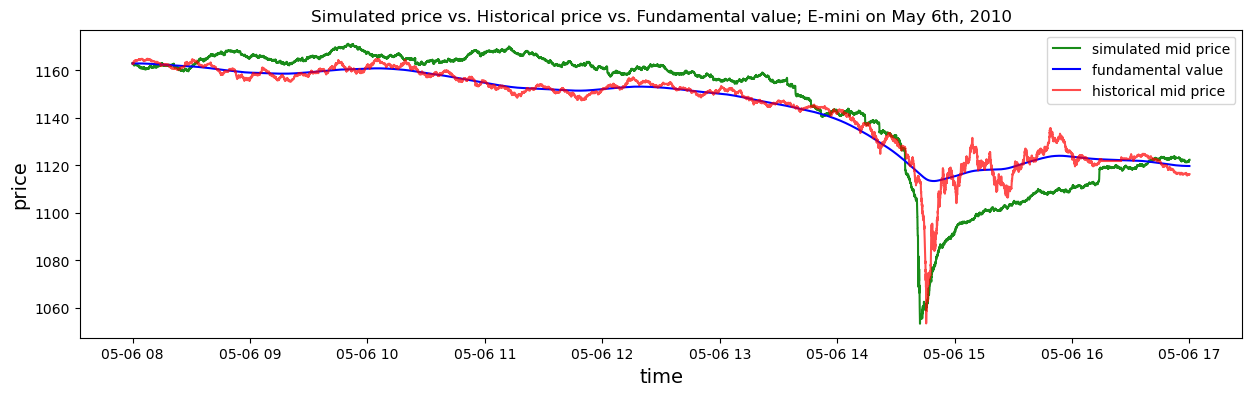

In [39]:
# For including in paper
left = pd.to_datetime(datestr + ' 08:00:00')
right = pd.to_datetime(datestr + ' 17:00:00')
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(mp.loc[left:right], 'g', alpha=0.9, label='simulated mid price')
ax.plot(fv.loc[left:right], 'b', label='fundamental value')
ax.plot(mid.loc[left:right], 'r', alpha=0.7, label='historical mid price')
ax.set_title('Simulated price vs. Historical price vs. Fundamental value; E-mini on May 6th, 2010')
ax.legend(loc='best')
ax.set_xlabel('time', size=14)
ax.set_ylabel('price', size=14)
plt.show()

Text(0.5, 1.0, 'Simulation')

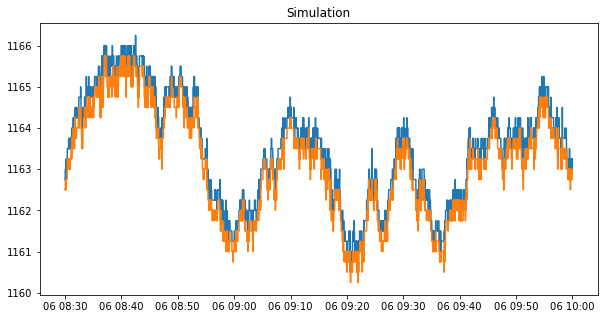

In [248]:
a0, b0 = md['a0'], md['b0']
left = pd.to_datetime(datestr + ' 08:30:00')
right = pd.to_datetime(datestr + ' 10:00:00')
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(a0.loc[left:right])
ax.plot(b0.loc[left:right])
ax.set_title("Simulation")
# ax.set_ylim((124.5, 127.5))

Simulated: 
L    534469
C    505159
M     27645
Name: OrdType, dtype: int64
1067273
MM     805719
ZI     241543
HMT     10740
FT       7465
MT       1739
INS        67
Name: TraderType, dtype: int64


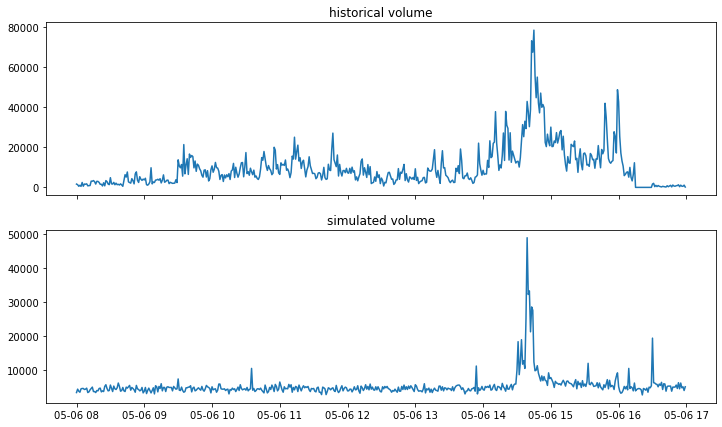

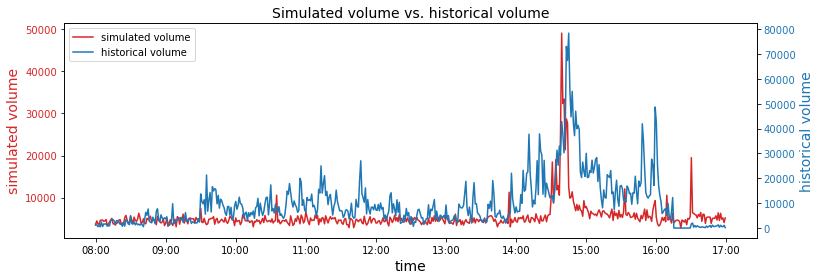

In [249]:
print('Simulated: ')
print(orders['OrdType'].value_counts())
print(len(orders))
print(orders['TraderType'].value_counts())
s_volume = trades['vol'].resample('1min').sum().fillna(0)
fig, ax = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
ax[0].plot(h_volume)
ax[1].plot(s_volume)
ax[0].set_title('historical volume')
ax[1].set_title('simulated volume')
plt.show()
fig, ax1 = plt.subplots(figsize=(11.5, 4))
color = 'tab:red'
ax1.set_xlabel('time', size=14)
ax1.set_ylabel('simulated volume', color=color, size=14)
ax1.plot(s_volume, color=color, label='simulated volume')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('historical volume', color=color, size=14)  # we already handled the x-label with ax1
ax2.plot(h_volume, color=color, label='historical volume')
ax2.tick_params(axis='y', labelcolor=color)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.set_title('Simulated volume vs. historical volume', size=14)
fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax2.transAxes)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Text(0.5, 1.0, 'LOB depth - simulated')

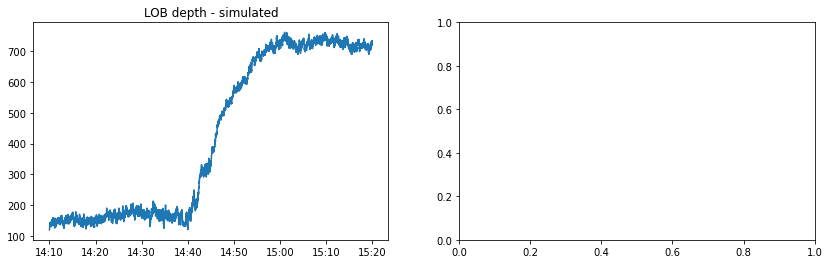

In [250]:
# (l1B['depth']+l1S['depth']).plot(title='LOB depth - noise trader simulation')
left = pd.to_datetime(datestr + ' 14:10:00')
right = pd.to_datetime(datestr + ' 15:20:00')
import matplotlib.dates as mdates
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot((l1B['depth']+l1S['depth']).loc[left:right][::5])
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].set_title('LOB depth - simulated')
# ax[1].plot(h_depth[::5])
# ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# ax[1].set_title('LOB depth - historical')


In [251]:
pos

,ZIpos,FTpos,MTpos,HMTpos,MMpos,STpos,INSpos,step
time,,,,,,,,
2010-05-06 08:00:00.000,0,0,0,0,0,0,120000,0
2010-05-06 08:00:00.100,0,0,0,0,0,0,120000,1
2010-05-06 08:00:00.200,0,0,0,0,0,0,120000,2
2010-05-06 08:00:00.300,-100,0,0,0,100,0,120000,3
2010-05-06 08:00:00.400,-100,0,0,0,100,0,120000,4
...,...,...,...,...,...,...,...,...
2010-05-06 16:59:58.500,-15140,191267,-4400,-387,-48663,0,-2677,323985
2010-05-06 16:59:58.600,-15140,191267,-4400,-387,-48663,0,-2677,323986
2010-05-06 16:59:58.700,-15140,191267,-4400,-387,-48663,0,-2677,323987


In [252]:
# Position analysis
pos.max()

ZIpos      34510
FTpos     215367
MTpos        700
HMTpos      6931
MMpos      82060
STpos          0
INSpos    120000
step      323989
dtype: int64

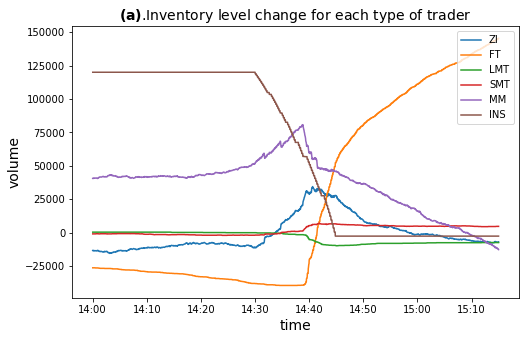

In [253]:
left = pd.to_datetime(datestr + ' 14:00:00')
right = pd.to_datetime(datestr + ' 15:15:00')
tmp_pos = pos.loc[left:right].drop(['STpos', 'step'], axis=1)
# tmp_pos = pos.loc[left:right].drop(['INSpos', 'step'], axis=1)
tmp_pos.rename(columns={'MTpos': 'LMTpos', 'HMTpos': 'SMTpos'}, inplace=True)
fig, ax = plt.subplots(figsize=(8,5))
for col in tmp_pos.columns:
    ax.plot(tmp_pos[col][::20], label=col[:-3])
ax.legend(loc='upper right')
ax.set_title(r'$\bf{(a)}$.Inventory level change for each type of trader', size=14)
ax.set_xlabel('time', size=14)
ax.set_ylabel('volume', size=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.show()

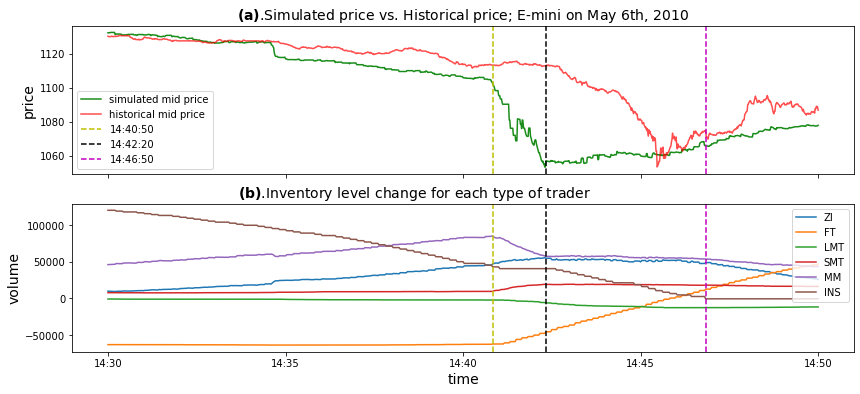

In [229]:
left = pd.to_datetime(datestr + ' 14:30:00')
right = pd.to_datetime(datestr + ' 14:50:00')
tmp_pos = pos.loc[left:right].drop(['STpos', 'step'], axis=1)
tmp_pos.rename(columns={'MTpos': 'LMTpos', 'HMTpos': 'SMTpos'}, inplace=True)

t1, t2, t3 = pd.to_datetime(datestr + ' 14:40:50'), pd.to_datetime(datestr + ' 14:42:20'), pd.to_datetime(datestr + ' 14:46:50')


fig, ax = plt.subplots(2,1,figsize=(14,6), sharex=True)
ax[0].plot(mp.loc[left:right], 'g', alpha=0.9, label='simulated mid price')
# ax[0].plot(fv.loc[left:right], 'b', label='fundamental value')
ax[0].plot(mid.loc[left:right], 'r', alpha=0.7, label='historical mid price')
ax[0].set_title(r'$\bf{(a)}$.Simulated price vs. Historical price; E-mini on May 6th, 2010', size=14)
# ax[0].legend(loc='best')
# ax[0].set_xlabel('time', size=14)
ax[0].set_ylabel('price', size=14)
# plt.show()

# fig, ax = plt.subplots(figsize=(7,4))
for col in tmp_pos.columns:
    ax[1].plot(tmp_pos[col][::20], label=col[:-3])
ax[1].legend(loc='upper right')
ax[1].set_title(r'$\bf{(b)}$.Inventory level change for each type of trader                       ', size=14)
ax[1].set_xlabel('time', size=14)
ax[1].set_ylabel('volume', size=14)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax[0].axvline(t1, color='y', ls='dashed', label=str(t1)[-8:])
ax[1].axvline(t1, color='y', ls='dashed')
    
ax[0].axvline(t2, color='k', ls='dashed', label=str(t2)[-8:])
ax[1].axvline(t2, color='k', ls='dashed')

ax[0].axvline(t3, color='m', ls='dashed', label=str(t3)[-8:])
ax[1].axvline(t3, color='m', ls='dashed')
ax[0].legend(loc='best')
plt.show()

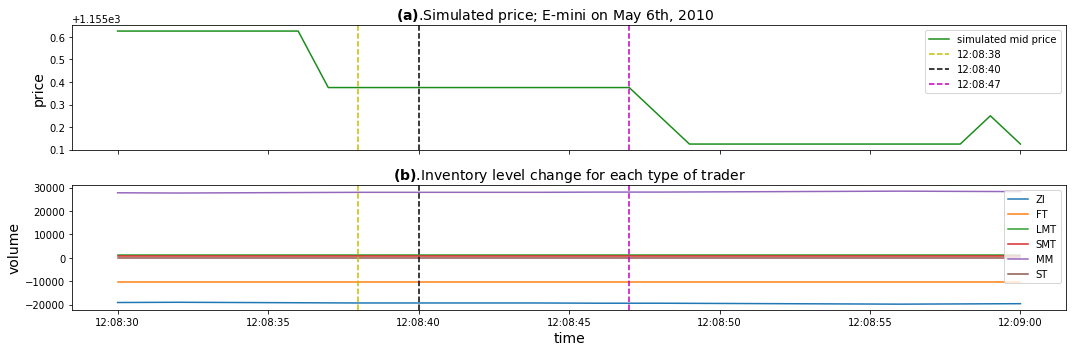

In [87]:
# For mini flash crash
# pos_limit=4000
left = pd.to_datetime(datestr + ' 12:08:30')
right = pd.to_datetime(datestr + ' 12:09:00')
tmp_pos = pos.loc[left:right].drop(['INSpos', 'step'], axis=1)
tmp_pos.rename(columns={'MTpos': 'LMTpos', 'HMTpos': 'SMTpos'}, inplace=True)

t1, t2, t3 = pd.to_datetime(datestr + ' 12:08:38'), pd.to_datetime(datestr + ' 12:08:40'), pd.to_datetime(datestr + ' 12:08:47')


fig, ax = plt.subplots(2,1,figsize=(15,5), sharex=True)
ax[0].plot(mp.loc[left:right], 'g', alpha=0.9, label='simulated mid price')
# ax[0].plot(fv.loc[left:right], 'b', label='fundamental value')
# ax[0].plot(mid.loc[left:right], 'r', alpha=0.7, label='historical mid price')
ax[0].set_title(r'$\bf{(a)}$.Simulated price; E-mini on May 6th, 2010       ', size=14)
# ax[0].legend(loc='best')
# ax[0].set_xlabel('time', size=14)
ax[0].set_ylabel('price', size=14)
# plt.show()

# fig, ax = plt.subplots(figsize=(7,4))
for col in tmp_pos.columns:
    ax[1].plot(tmp_pos[col][::20], label=col[:-3])
ax[1].legend(loc='upper right')
ax[1].set_title(r'$\bf{(b)}$.Inventory level change for each type of trader', size=14)
ax[1].set_xlabel('time', size=14)
ax[1].set_ylabel('volume', size=14)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

ax[0].axvline(t1, color='y', ls='dashed', label=str(t1)[-8:])
ax[1].axvline(t1, color='y', ls='dashed')
    
ax[0].axvline(t2, color='k', ls='dashed', label=str(t2)[-8:])
ax[1].axvline(t2, color='k', ls='dashed')

ax[0].axvline(t3, color='m', ls='dashed', label=str(t3)[-8:])
ax[1].axvline(t3, color='m', ls='dashed')
ax[0].legend(loc='best')
fig.tight_layout()
plt.show()

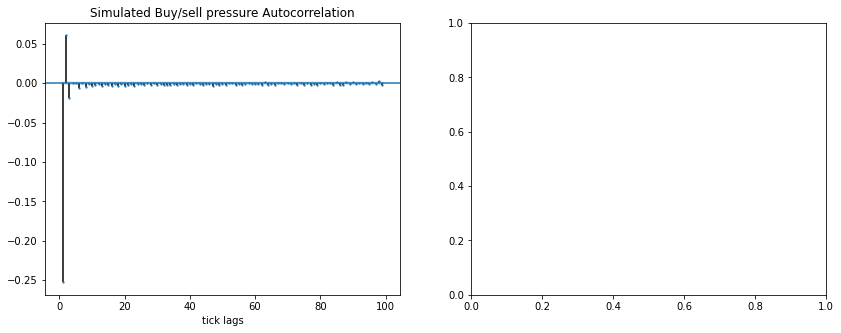

In [199]:
# Orders autocorrelation analysis
# orders['OrdType'].value_counts()
orders_data = orders.copy()
orders_data['tmp1'] = orders_data['side'].apply(lambda x: 1 if x=='B' else -1)
orders_data['tmp2'] = orders_data['OrdType'].apply(lambda x: -1 if x=='C' else 1)
orders_data['pressure'] = orders_data['tmp1'] * orders_data['tmp2']

p_series = orders_data[(orders_data['pressure']!=0) & (orders_data['OrdType']!='M')]['pressure']
# p_series = orders_data[orders_data['TraderType'] == 'MT']['pressure']
# p_series = orders_data[orders_data['TraderType'] == 'FT']['pressure']
from statsmodels.graphics.tsaplots import plot_acf
fig, axs = plt.subplots(1,2, figsize=(14, 5))
plot_acf(p_series, ax=axs[0], lags=range(1,100), markersize=1.2, fft=True)
axs[0].set_title('Simulated Buy/sell pressure Autocorrelation')
#plot_acf(real_p_series, ax=axs[1], lags=range(1,100), markersize=1.2, fft=True)
#axs[1].set_title('Real Buy/sell pressure Autocorrelation')
# ax.set_title('Total Order buy/sell Pressure Autocorrelation')
# ax.set_title('Momentum trader Order buy/sell Pressure Autocorrelation - alpha')
# ax.set_title('Fundamental trader Order buy/sell Pressure Autocorrelation - alpha')
axs[0].set_xlabel('tick lags')
#axs[1].set_xlabel('tick lags')
#axs[1].plot(np.arange(1, 21), acf(real_p_series, nlags=20, fft=True)[1:])
plt.show()

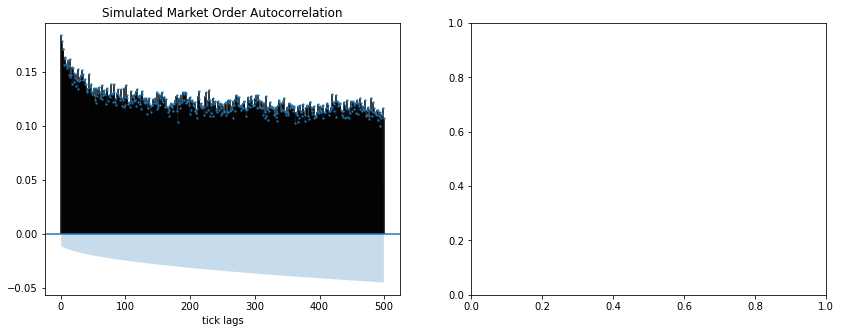

In [200]:
# market order autocorrelation
mo_series_s = orders_data[orders_data['OrdType'] == 'M']['pressure']
# mo_series_s = orders_data[(orders_data['OrdType'] == 'M') & (orders_data['TraderType'] == 'MT')]['pressure']
# mo_series_s = orders_data[(orders_data['OrdType'] == 'M') & (orders_data['TraderType'] == 'FT')]['pressure']
from statsmodels.graphics.tsaplots import plot_acf
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(mo_series_s, ax=axs[0], lags=range(1,500), markersize=1.2, fft=True)
axs[0].set_title('Simulated Market Order Autocorrelation')
#plot_acf(mo_sign, ax=axs[1], lags=range(1,500), markersize=1.2)
#axs[1].set_title('Real Market Order Autocorrelation')
# ax.set_title('All traders Market Order Autocorrelation')
# ax.set_title('Momentum trader Market Order Autocorrelation - alpha')
# ax.set_title('Fundamental trader Market Order Autocorrelation - alpha')
axs[0].set_xlabel('tick lags')
#axs[1].set_xlabel('tick lags')
plt.show()

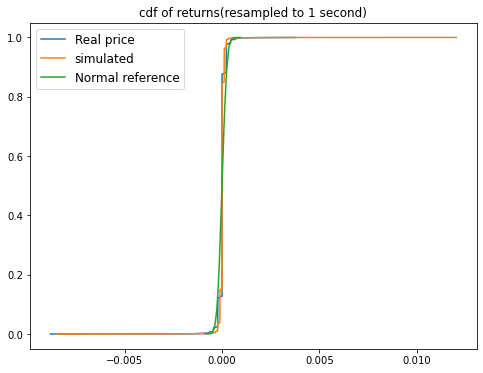

excess kurtosis of historical return: 240.86749739306106
excess kurtosis of simulated return: 1592.4587325187342
excess kurtosis of normal distribution: 0.0011657018331563407
skewness of historical return: -3.9822921218415415
skewness of simulated return: 8.41879489882667
skewness of normal distribution: 0.011704323440394574
KS test:
0.09210072683894156
volatility: 
0.0001958278079766854 0.00015431171622787596 difference:  4.151609174880944e-05


In [201]:
from scipy.stats import cumfreq
from scipy.stats import kurtosis, skew, ks_2samp
# a = (mid.values[1:] / mid.values[:-1] - 1) * 10000
# b = (mp.values[1:] / mp.values[:-1] - 1) * 10000
a = h_ret
b = s_ret
c = np.random.normal(a.mean(), a.std(), (len(a)+len(b))//2)
# num_bins =  100
# b = cumfreq(a, num_bins)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.sort(a), np.linspace(0, 1, len(a), endpoint=False), label='Real price')
ax.plot(np.sort(b), np.linspace(0, 1, len(b), endpoint=False), label='simulated')
ax.plot(np.sort(c), np.linspace(0, 1, len(c), endpoint=False), label='Normal reference')
# ax.set_xlim((-50, 50))
ax.legend(loc='best', prop={'size': 12})
ax.set_title('cdf of returns(resampled to 1 second)')
plt.show()
# Heavy tail analysis
print('excess kurtosis of historical return: {}'.format(kurtosis(a)))
print('excess kurtosis of simulated return: {}'.format(kurtosis(b)))
print('excess kurtosis of normal distribution: {}'.format(kurtosis(c)))
print('skewness of historical return: {}'.format(skew(a)))
print('skewness of simulated return: {}'.format(skew(b)))
print('skewness of normal distribution: {}'.format(skew(c)))
print('KS test:')
d = np.random.uniform(0, 1, len(a))
print(ks_2samp(a, b).statistic)
print('volatility: ')
print(a.std(), b.std(), 'difference: ', a.std()-b.std()) #

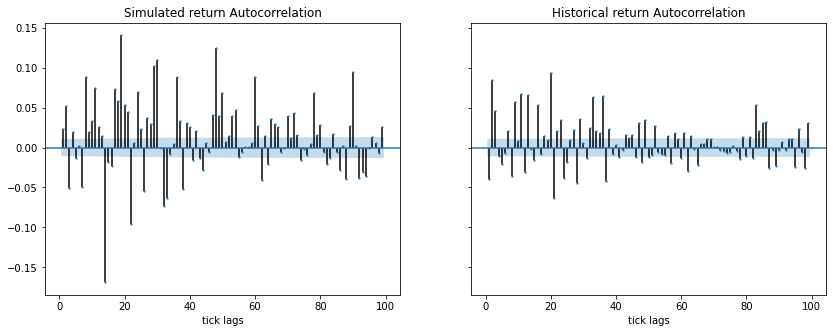

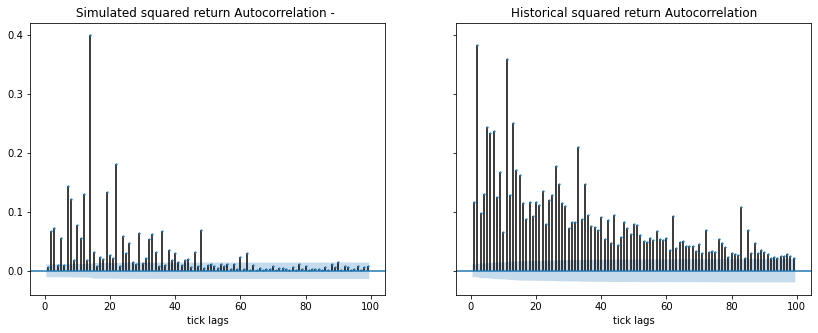

In [202]:
# return autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
plot_acf(b, ax=axs[0], lags=range(1,100), markersize=1.2, fft=True)
axs[0].set_title('Simulated return Autocorrelation')
plot_acf(a, ax=axs[1], lags=range(1,100), markersize=1.2, fft=True)
axs[1].set_title('Historical return Autocorrelation')
axs[0].set_xlabel('tick lags')
axs[1].set_xlabel('tick lags')
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
plot_acf(b**2, ax=axs[0], lags=range(1,100), markersize=1.2, fft=True)
axs[0].set_title('Simulated squared return Autocorrelation - ')
plot_acf(a**2, ax=axs[1], lags=range(1,100), markersize=1.2, fft=True)
axs[1].set_title('Historical squared return Autocorrelation')
axs[0].set_xlabel('tick lags')
axs[1].set_xlabel('tick lags')
plt.show()

In [203]:
from itertools import chain
ll = 3
LAGS = list(chain(*[[x+i for i in range(ll)] for x in (30, 60, 90)]))
LAGS2 = list(chain(*[[x+i for i in range(ll)] for x in (1, 30, 60, 90)]))
print(LAGS, LAGS2)

[30, 31, 32, 60, 61, 62, 90, 91, 92] [1, 2, 3, 30, 31, 32, 60, 61, 62, 90, 91, 92]


In [204]:
# from CMECalibration.distance_calc import *
# from CMECalibration.moment_coverage_util import *
# hill_estimator(h_ret, tail=0.05)

In [205]:
sim_vol = np.std(s_ret) * np.sqrt(len(s_ret)*252)
print(sim_vol)

0.4409184503401261


In [206]:
his_vol = np.std(h_ret) * np.sqrt(len(h_ret)*252)
print(his_vol)

0.5595519788117057


In [207]:
# hill_interval, vol_interval, acf_interval, acf2_interval = get_confidence_interval(h_ret, ll, LAGS, LAGS2, block_size=1800)